In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

In [2]:
# Loading Data
url = "https://raw.githubusercontent.com/gringler8/data5322project/main/NIJ_s_Recidivism_Challenge_Full_Dataset_20240520.csv"
data = pd.read_csv(url)
print(data.shape)

(25835, 54)


In [3]:
# Replace NA/blanks in Gang_Affiliated with "Unknown"
data['Gang_Affiliated'] = data['Gang_Affiliated'].fillna('Unknown')

# Filter out rows with any NAs in the entire dataset
filtered_data = data.dropna().copy()

# Convert specified columns to categorical variables
categorical_columns = [
    'Gender',
    'Race',
    'Age_at_Release',
    'Gang_Affiliated',
    'Supervision_Level_First',
    'Education_Level',
    'Prison_Offense',
    'Prison_Years',
    'Prior_Conviction_Episodes_Viol',
    'Prior_Conviction_Episodes_PPViolationCharges',
    'Prior_Conviction_Episodes_DomesticViolenceCharges',
    'Prior_Conviction_Episodes_GunCharges',
    'Prior_Revocations_Parole',
    'Prior_Revocations_Probation',
    'Condition_MH_SA',
    'Condition_Cog_Ed',
    'Condition_Other',
    'Violations_ElectronicMonitoring',
    'Violations_Instruction',
    'Violations_FailToReport',
    'Violations_MoveWithoutPermission',
    'Employment_Exempt'
]

for column in categorical_columns:
    filtered_data[column] = filtered_data[column].astype('category')

# Clean and convert Avg_Days_per_DrugTest to float by removing commas
filtered_data['Avg_Days_per_DrugTest'] = filtered_data['Avg_Days_per_DrugTest'].str.replace(',', '').astype(float)
filtered_data['ID'] = filtered_data['ID'].str.replace(',', '').astype(float)

# Update columns based on the conditions
column_conditions = {
    'Dependents': (3, '3 or more'),
    'Prior_Arrest_Episodes_Felony': (10, '10 or more'),
    'Prior_Arrest_Episodes_Misd': (6, '6 or more'),
    'Prior_Arrest_Episodes_Violent': (3, '3 or more'),
    'Prior_Arrest_Episodes_Property': (5, '5 or more'),
    'Prior_Arrest_Episodes_Drug': (5, '5 or more'),
    'Prior_Arrest_Episodes_PPViolationCharges': (5, '5 or more'),
    'Prior_Conviction_Episodes_Felony': (3, '3 or more'),
    'Prior_Conviction_Episodes_Misd': (4, '4 or more'),
    'Prior_Conviction_Episodes_Prop': (3, '3 or more'),
    'Prior_Conviction_Episodes_Drug': (2, '2 or more'),
    'Delinquency_Reports': (4, '4 or more'),
    'Program_Attendances': (10, '10 or more'),
    'Program_UnexcusedAbsences': (3, '3 or more'),
    'Residence_Changes': (3, '3 or more')
}

# Update the columns based on the conditions
for column, (numeric_value, condition_str) in column_conditions.items():
    filtered_data[column] = filtered_data[column].replace(condition_str, numeric_value).astype(int)

# Columns to exclude from model creation
columns_to_exclude = [
    'Recidivism_Within_3years',
    'Recidivism_Arrest_Year1',
    'Recidivism_Arrest_Year2',
    'Recidivism_Arrest_Year3',
    'Training_Sample',
    'ID'
]

# Keep a separate copy of the excluded columns
excluded_columns_data = filtered_data[columns_to_exclude].copy()

# Drop the excluded columns from the dataset used for model creation
filtered_data_for_model = filtered_data.drop(columns=columns_to_exclude)

print(filtered_data_for_model.shape)

(16198, 48)


In [4]:
filtered_data_for_model.dtypes

,0
Gender,category
Race,category
Age_at_Release,category
Residence_PUMA,int64
Gang_Affiliated,category
Supervision_Risk_Score_First,float64
Supervision_Level_First,category
Education_Level,category
Dependents,int64
Prison_Offense,category


In [5]:

preprocessed_data = filtered_data_for_model.copy()


# Grouping Education_Level
education_groups = {
    'At least some college': 'College or Higher',   # Grouping some college and higher education into one category
    'Less than HS diploma': 'High School or Lower'   # Grouping less than high school diploma into one category
}
preprocessed_data['Education_Level'] = preprocessed_data['Education_Level'].map(education_groups)

# Convert categorical variables to appropriate data type
categorical_columns = ['Gender', 'Race', 'Age_at_Release', 'Supervision_Level_First', 'Education_Level', 'Prison_Offense', 'Employment_Exempt']
preprocessed_data[categorical_columns] = preprocessed_data[categorical_columns].astype('category')

# Grouping Race
race_groups = {
    'BLACK': 'Black',    # Grouping variations of Black ethnicity into one category
    'WHITE': 'White',    # Grouping variations of White ethnicity into one category
    # Add more groups if needed
}
preprocessed_data['Race'] = preprocessed_data['Race'].map(race_groups)

# Grouping Prison_Offense
prison_offense_groups = {
    'Drug': 'Drug Offense',          # Grouping drug-related offenses into one category
    'Violent/Non-Sex': 'Violent Offense',   # Grouping violent/non-sexual offenses into one category
    'Property': 'Property Offense',   # Grouping property-related offenses into one category
    # Add more groups if needed
}
preprocessed_data['Prison_Offense'] = preprocessed_data['Prison_Offense'].map(prison_offense_groups).astype('category')

pd.set_option('display.max_columns', 500)
#print(preprocessed_data.head())


# Exploring the dataset

<ipython-input-6-933b3423e814>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):


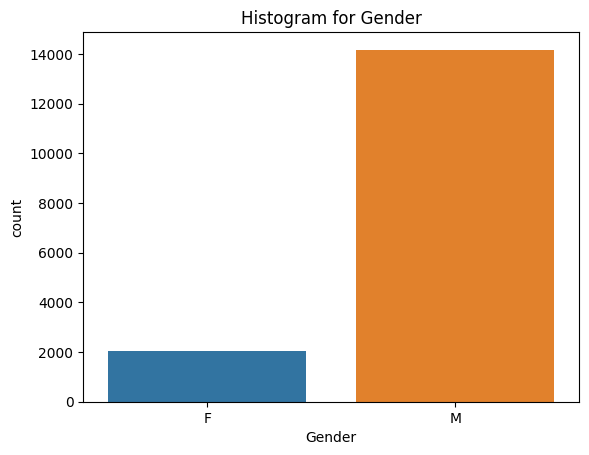

<ipython-input-6-933b3423e814>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):


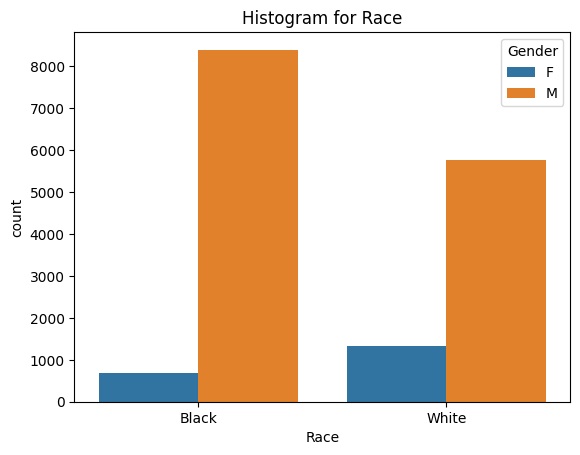

<ipython-input-6-933b3423e814>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):


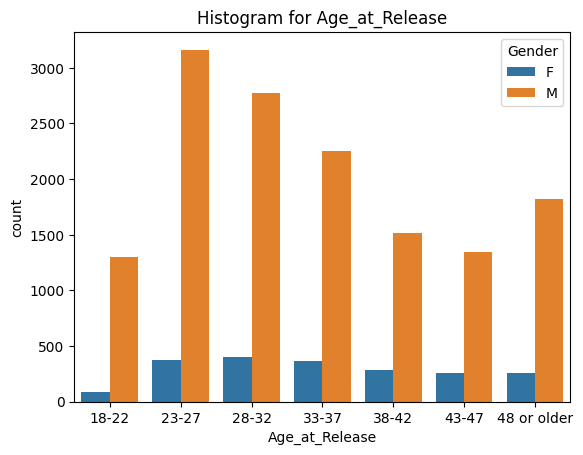

<ipython-input-6-933b3423e814>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):
<ipython-input-6-933b3423e814>:14: DeprecationWarning: is_int64_dtype is deprecated and will be removed in a future version. Use dtype == np.int64 instead.
  elif pd.api.types.is_int64_dtype(preprocessed_data[col]):


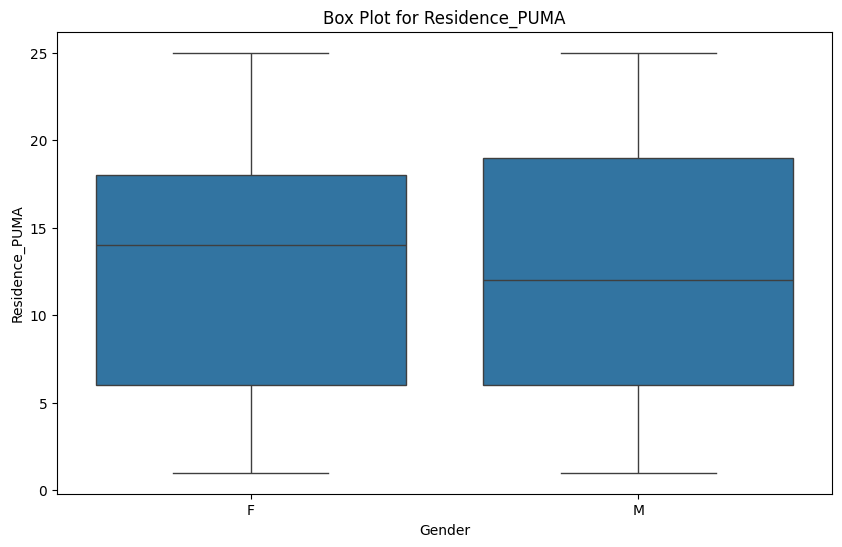

<ipython-input-6-933b3423e814>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):


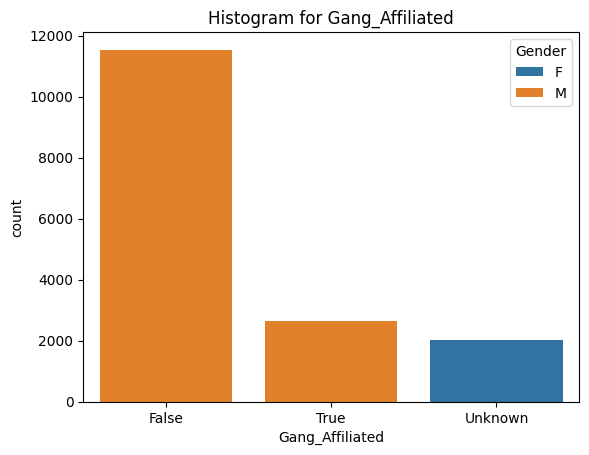

<ipython-input-6-933b3423e814>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):


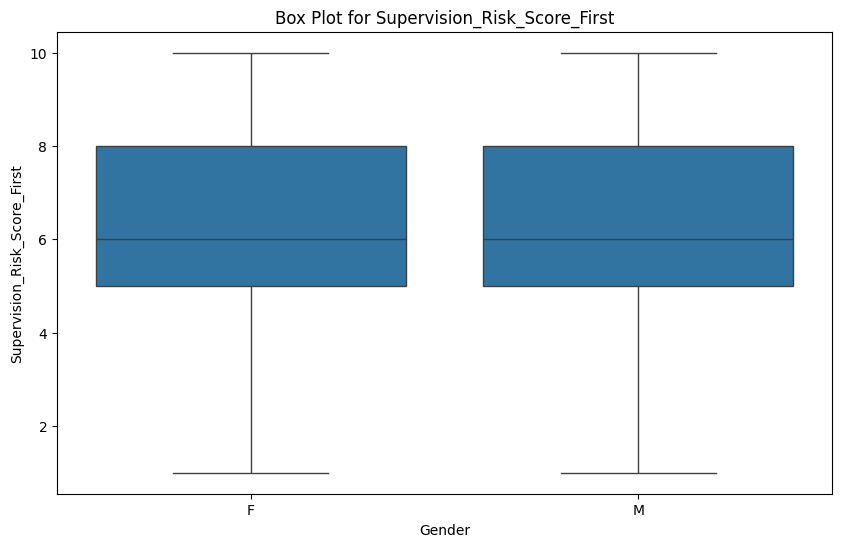

<ipython-input-6-933b3423e814>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):


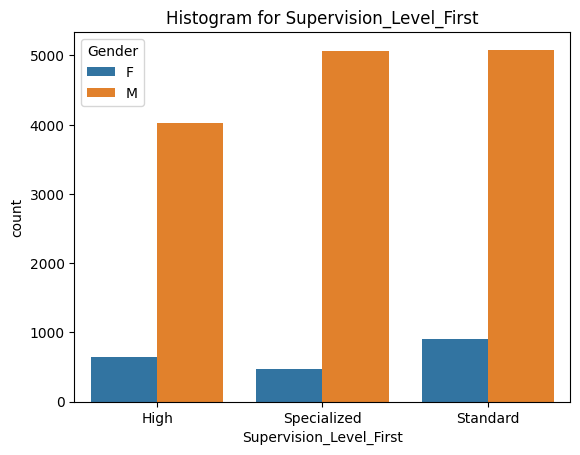

<ipython-input-6-933b3423e814>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):


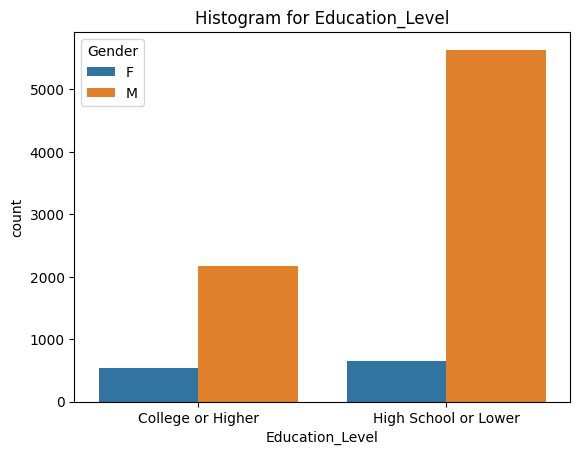

<ipython-input-6-933b3423e814>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):
<ipython-input-6-933b3423e814>:14: DeprecationWarning: is_int64_dtype is deprecated and will be removed in a future version. Use dtype == np.int64 instead.
  elif pd.api.types.is_int64_dtype(preprocessed_data[col]):


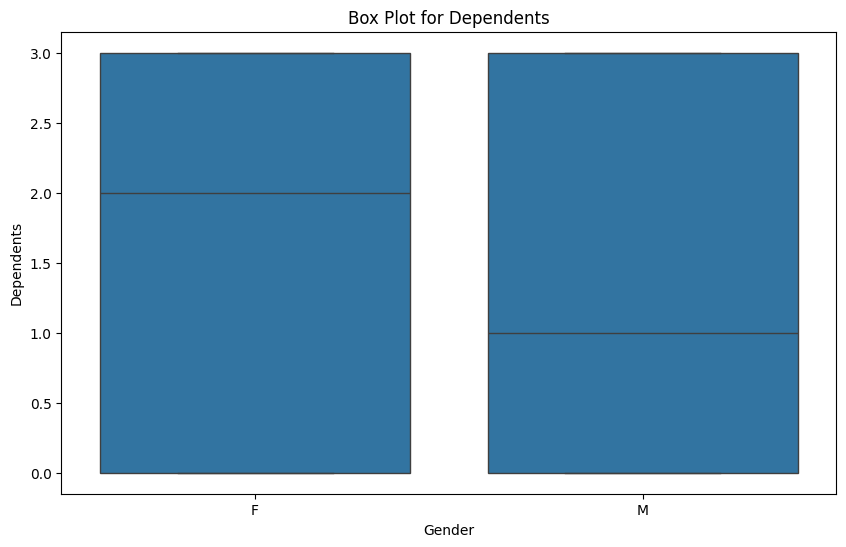

<ipython-input-6-933b3423e814>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):


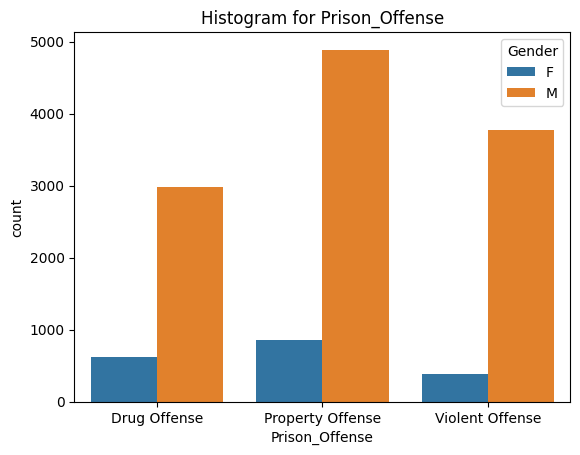

<ipython-input-6-933b3423e814>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):


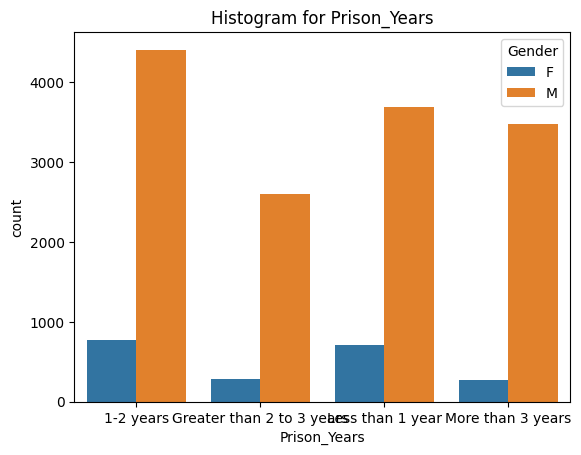

<ipython-input-6-933b3423e814>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):
<ipython-input-6-933b3423e814>:14: DeprecationWarning: is_int64_dtype is deprecated and will be removed in a future version. Use dtype == np.int64 instead.
  elif pd.api.types.is_int64_dtype(preprocessed_data[col]):


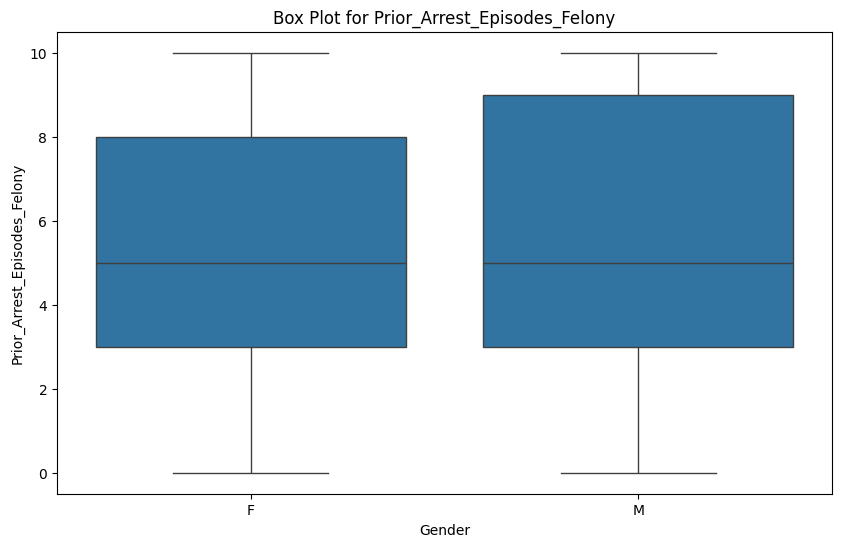

<ipython-input-6-933b3423e814>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):
<ipython-input-6-933b3423e814>:14: DeprecationWarning: is_int64_dtype is deprecated and will be removed in a future version. Use dtype == np.int64 instead.
  elif pd.api.types.is_int64_dtype(preprocessed_data[col]):


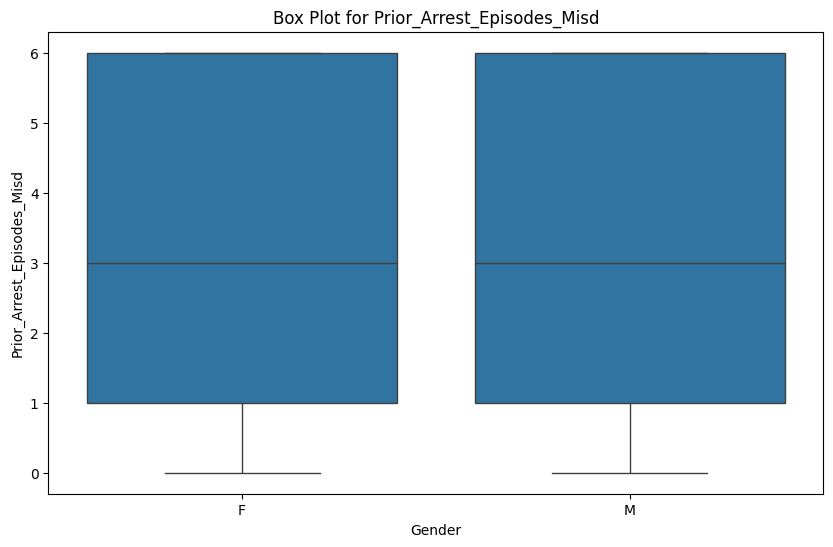

<ipython-input-6-933b3423e814>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):
<ipython-input-6-933b3423e814>:14: DeprecationWarning: is_int64_dtype is deprecated and will be removed in a future version. Use dtype == np.int64 instead.
  elif pd.api.types.is_int64_dtype(preprocessed_data[col]):


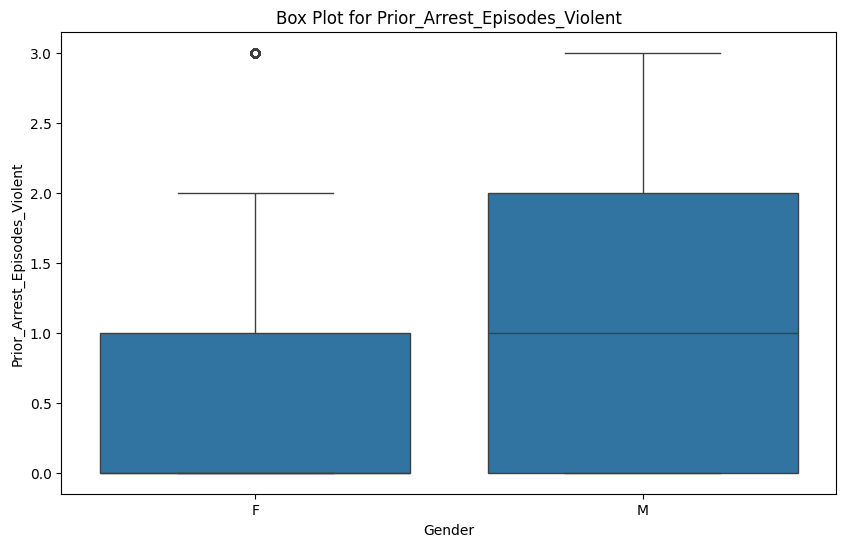

<ipython-input-6-933b3423e814>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):
<ipython-input-6-933b3423e814>:14: DeprecationWarning: is_int64_dtype is deprecated and will be removed in a future version. Use dtype == np.int64 instead.
  elif pd.api.types.is_int64_dtype(preprocessed_data[col]):


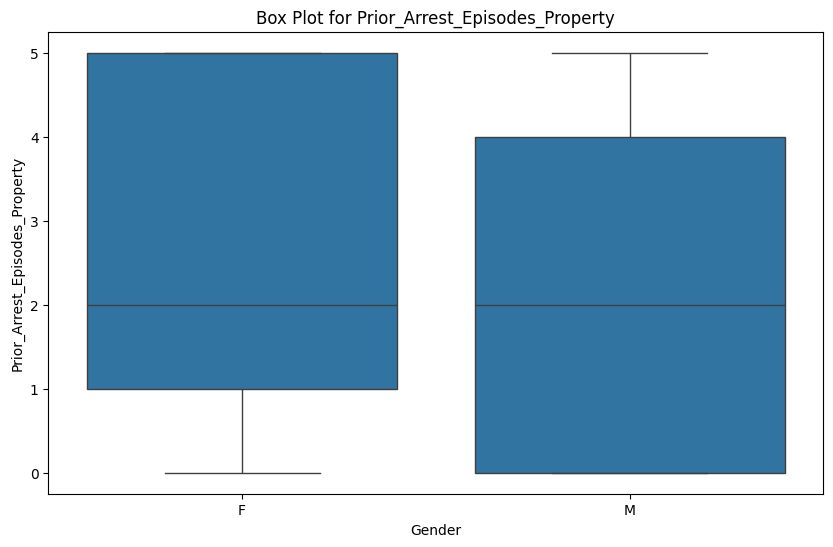

<ipython-input-6-933b3423e814>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):
<ipython-input-6-933b3423e814>:14: DeprecationWarning: is_int64_dtype is deprecated and will be removed in a future version. Use dtype == np.int64 instead.
  elif pd.api.types.is_int64_dtype(preprocessed_data[col]):


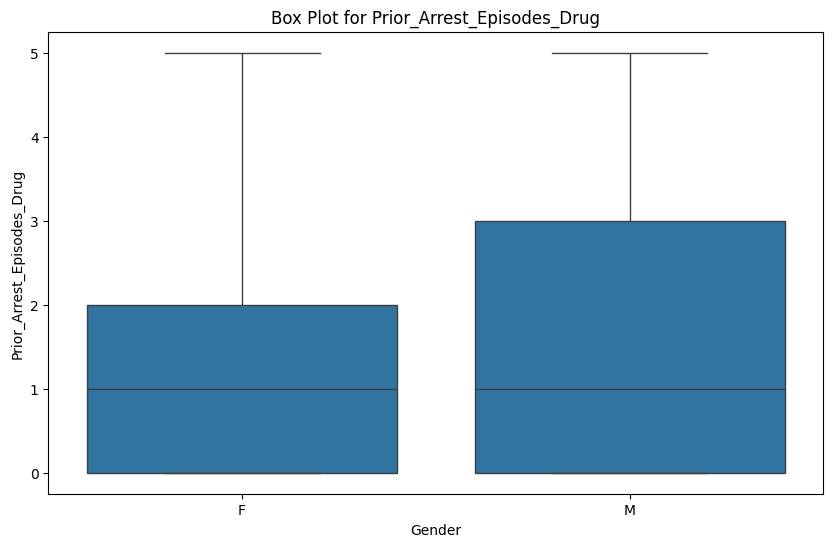

<ipython-input-6-933b3423e814>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):
<ipython-input-6-933b3423e814>:14: DeprecationWarning: is_int64_dtype is deprecated and will be removed in a future version. Use dtype == np.int64 instead.
  elif pd.api.types.is_int64_dtype(preprocessed_data[col]):


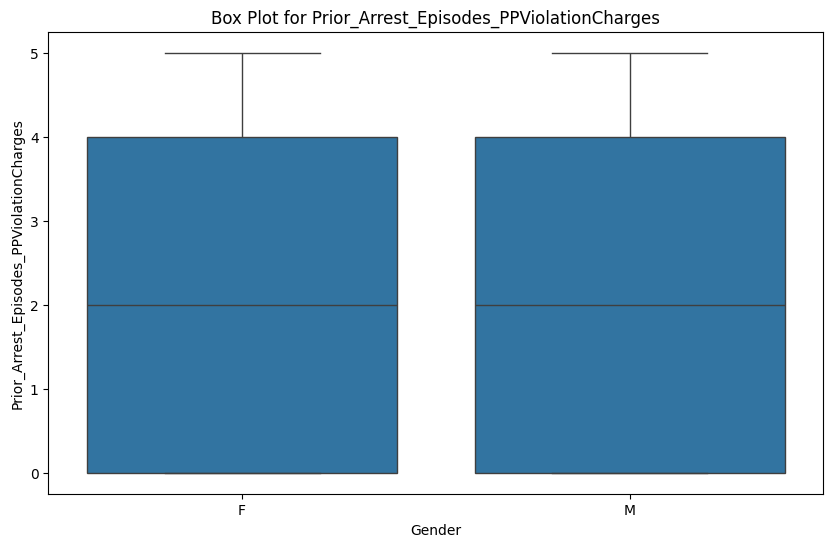

<ipython-input-6-933b3423e814>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):
<ipython-input-6-933b3423e814>:14: DeprecationWarning: is_int64_dtype is deprecated and will be removed in a future version. Use dtype == np.int64 instead.
  elif pd.api.types.is_int64_dtype(preprocessed_data[col]):


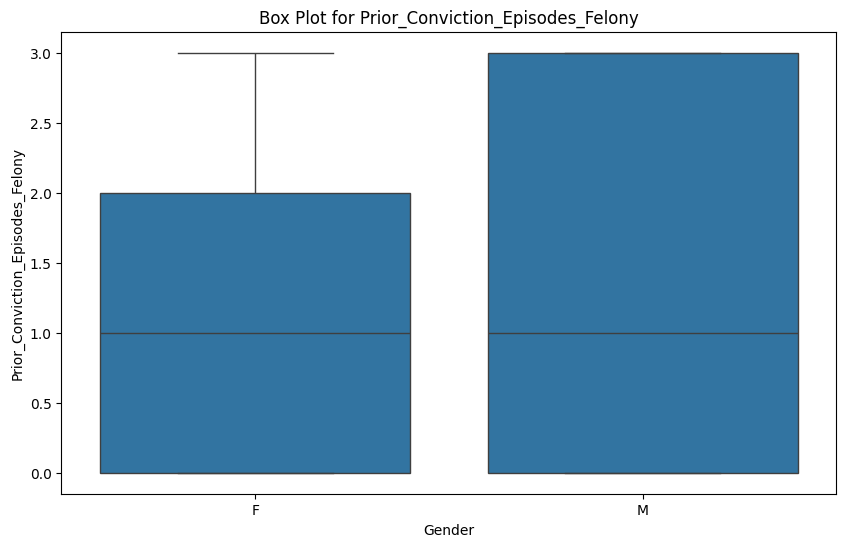

<ipython-input-6-933b3423e814>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):
<ipython-input-6-933b3423e814>:14: DeprecationWarning: is_int64_dtype is deprecated and will be removed in a future version. Use dtype == np.int64 instead.
  elif pd.api.types.is_int64_dtype(preprocessed_data[col]):


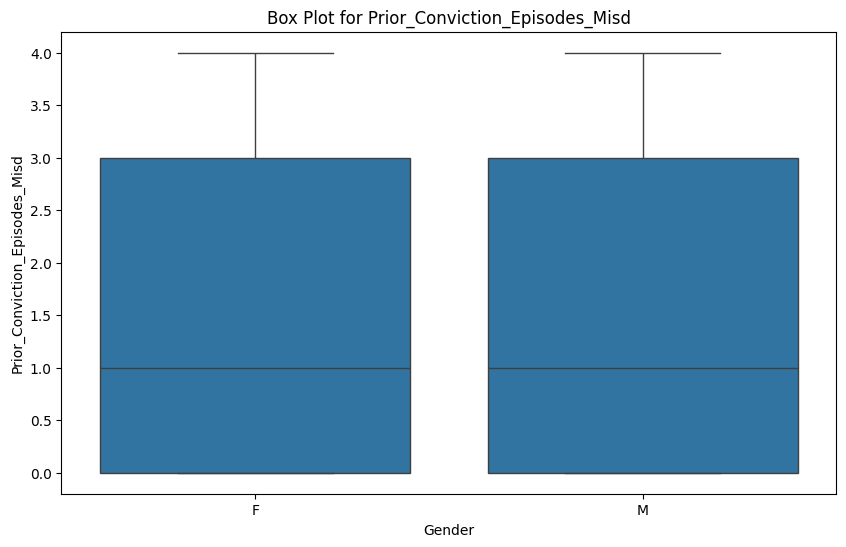

<ipython-input-6-933b3423e814>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):


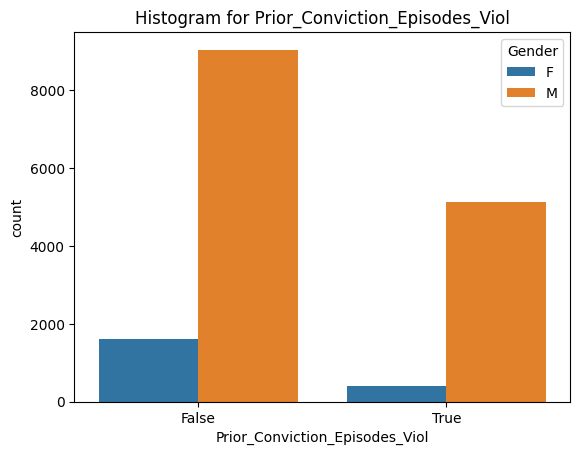

<ipython-input-6-933b3423e814>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):
<ipython-input-6-933b3423e814>:14: DeprecationWarning: is_int64_dtype is deprecated and will be removed in a future version. Use dtype == np.int64 instead.
  elif pd.api.types.is_int64_dtype(preprocessed_data[col]):


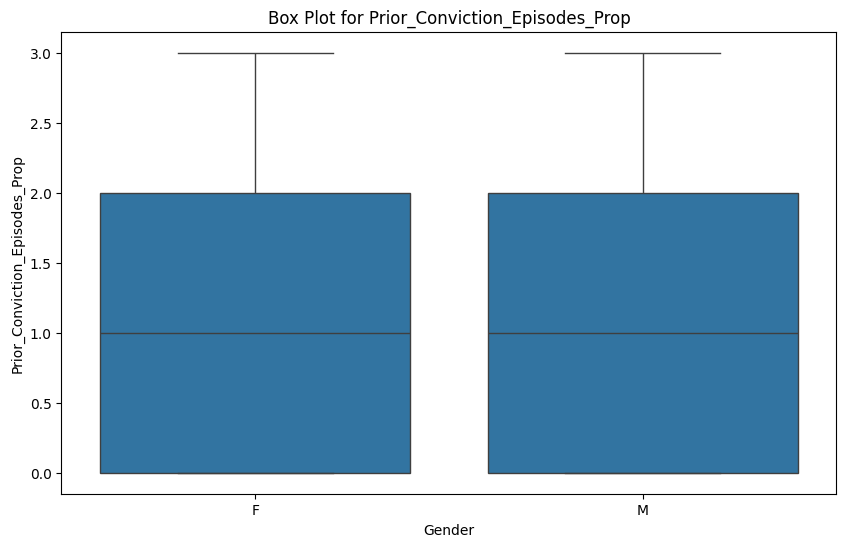

<ipython-input-6-933b3423e814>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):
<ipython-input-6-933b3423e814>:14: DeprecationWarning: is_int64_dtype is deprecated and will be removed in a future version. Use dtype == np.int64 instead.
  elif pd.api.types.is_int64_dtype(preprocessed_data[col]):


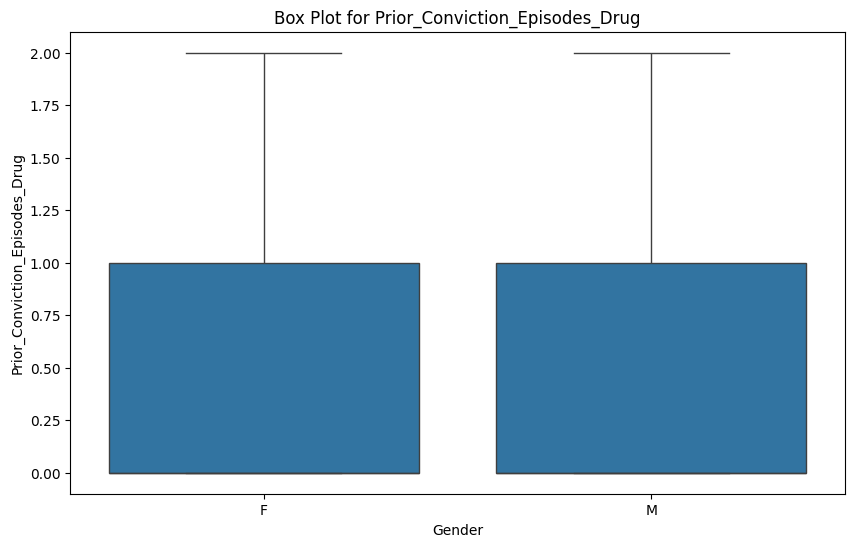

<ipython-input-6-933b3423e814>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):


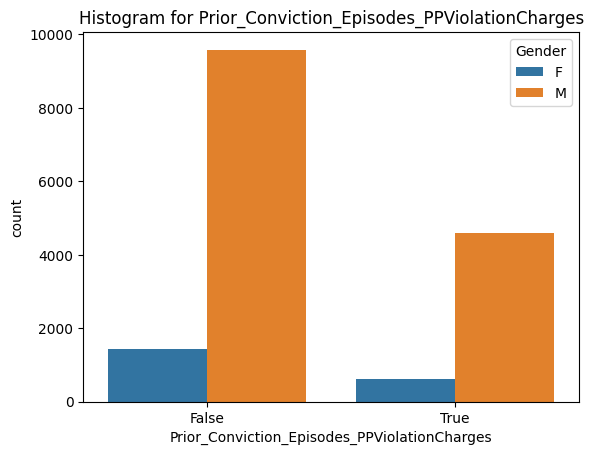

<ipython-input-6-933b3423e814>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):


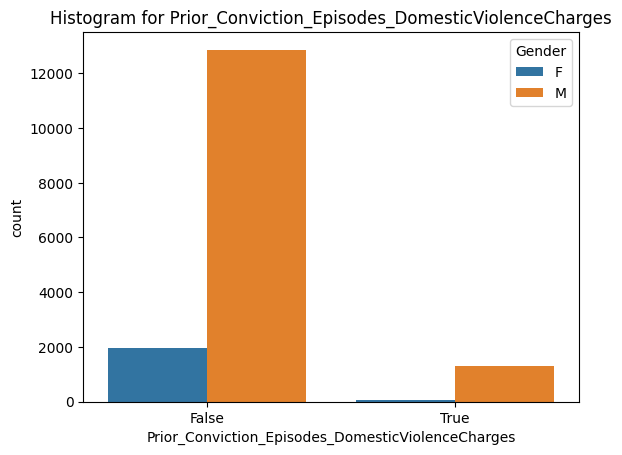

<ipython-input-6-933b3423e814>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):


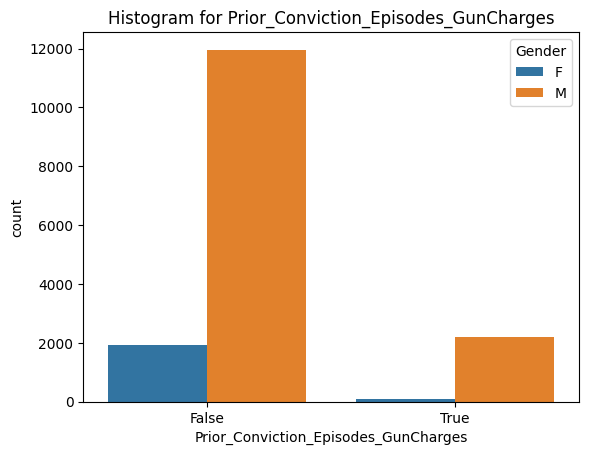

<ipython-input-6-933b3423e814>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):


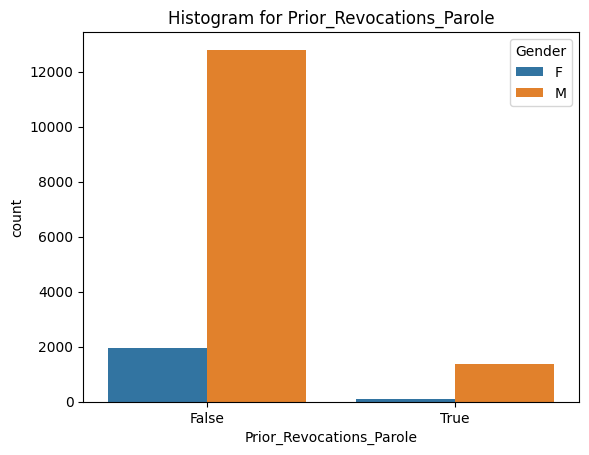

<ipython-input-6-933b3423e814>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):


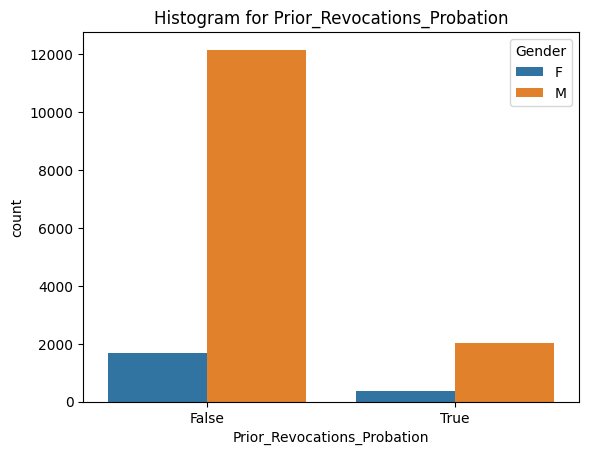

<ipython-input-6-933b3423e814>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):


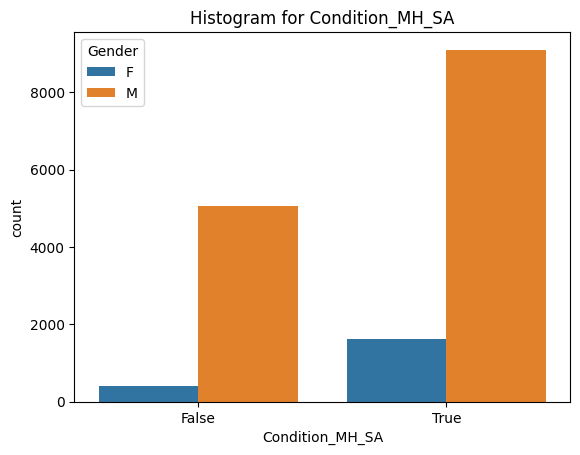

<ipython-input-6-933b3423e814>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):


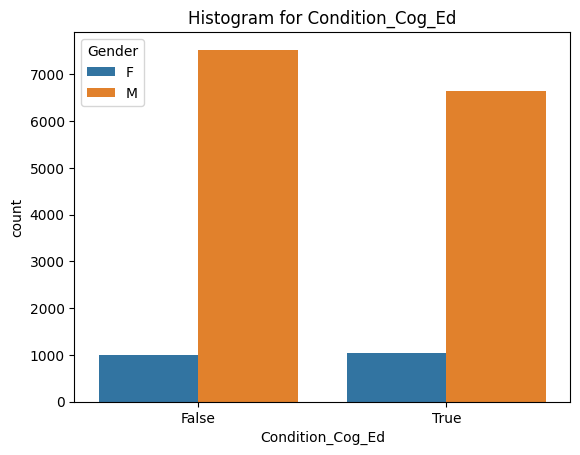

<ipython-input-6-933b3423e814>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):


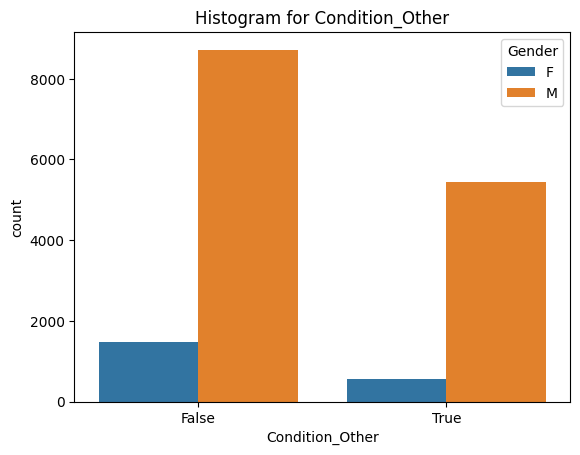

<ipython-input-6-933b3423e814>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):


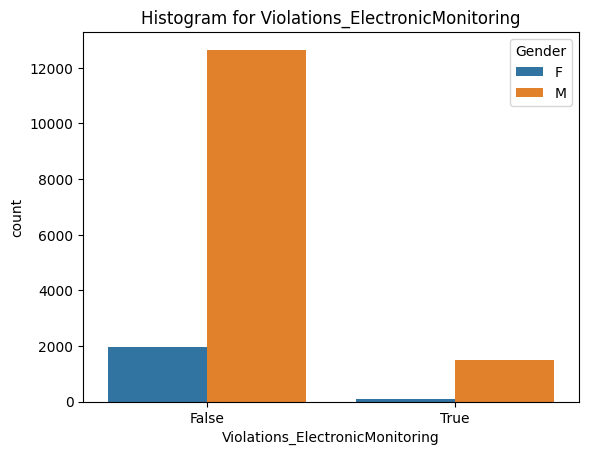

<ipython-input-6-933b3423e814>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):


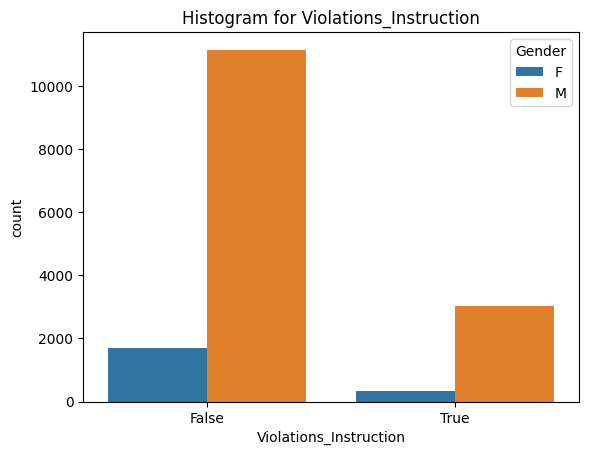

<ipython-input-6-933b3423e814>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):


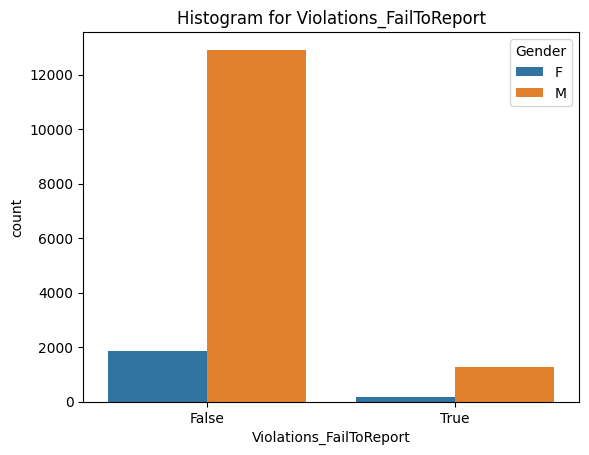

<ipython-input-6-933b3423e814>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):


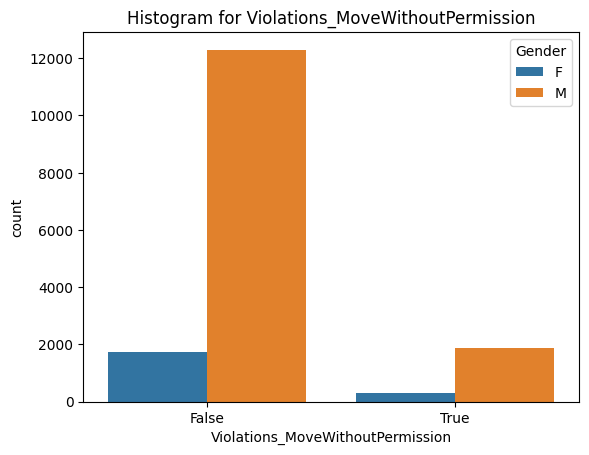

<ipython-input-6-933b3423e814>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):
<ipython-input-6-933b3423e814>:14: DeprecationWarning: is_int64_dtype is deprecated and will be removed in a future version. Use dtype == np.int64 instead.
  elif pd.api.types.is_int64_dtype(preprocessed_data[col]):


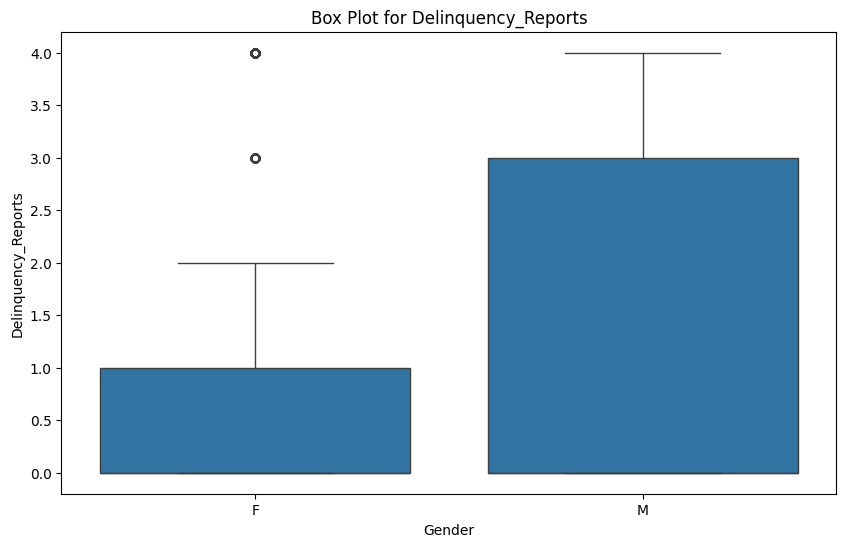

<ipython-input-6-933b3423e814>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):
<ipython-input-6-933b3423e814>:14: DeprecationWarning: is_int64_dtype is deprecated and will be removed in a future version. Use dtype == np.int64 instead.
  elif pd.api.types.is_int64_dtype(preprocessed_data[col]):


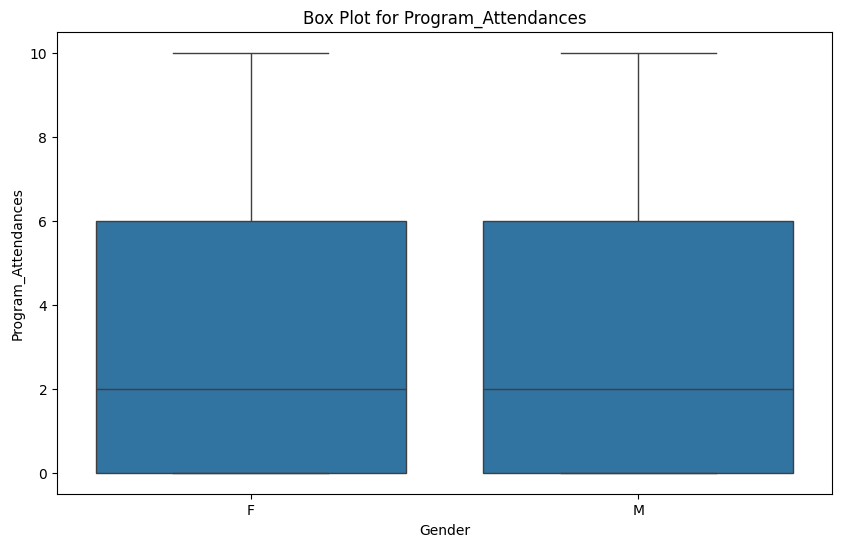

<ipython-input-6-933b3423e814>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):
<ipython-input-6-933b3423e814>:14: DeprecationWarning: is_int64_dtype is deprecated and will be removed in a future version. Use dtype == np.int64 instead.
  elif pd.api.types.is_int64_dtype(preprocessed_data[col]):


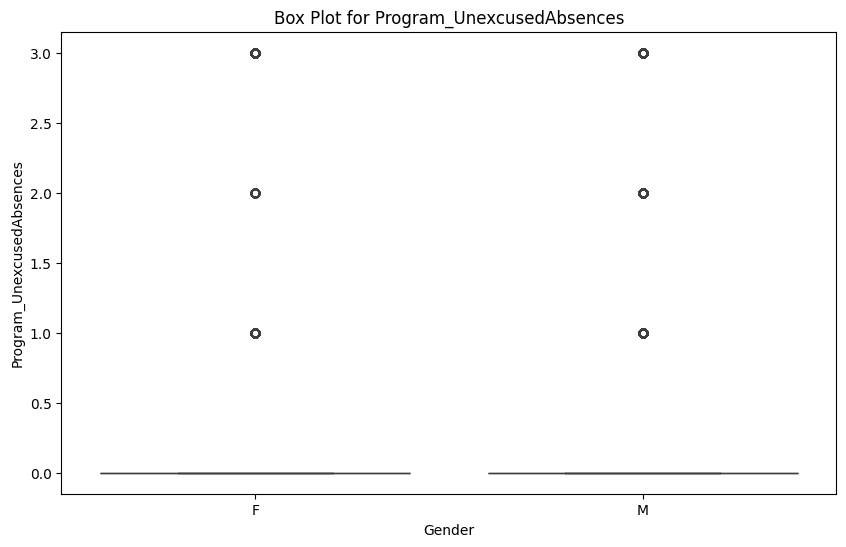

<ipython-input-6-933b3423e814>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):
<ipython-input-6-933b3423e814>:14: DeprecationWarning: is_int64_dtype is deprecated and will be removed in a future version. Use dtype == np.int64 instead.
  elif pd.api.types.is_int64_dtype(preprocessed_data[col]):


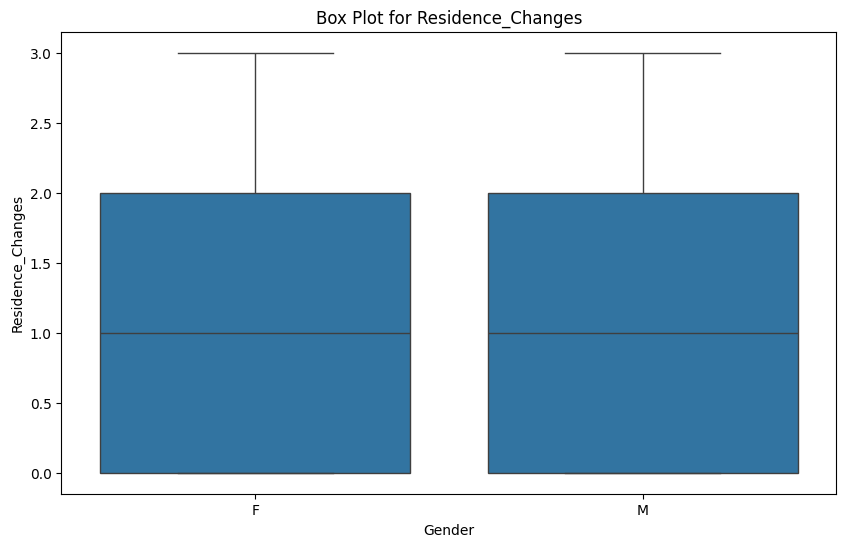

<ipython-input-6-933b3423e814>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):


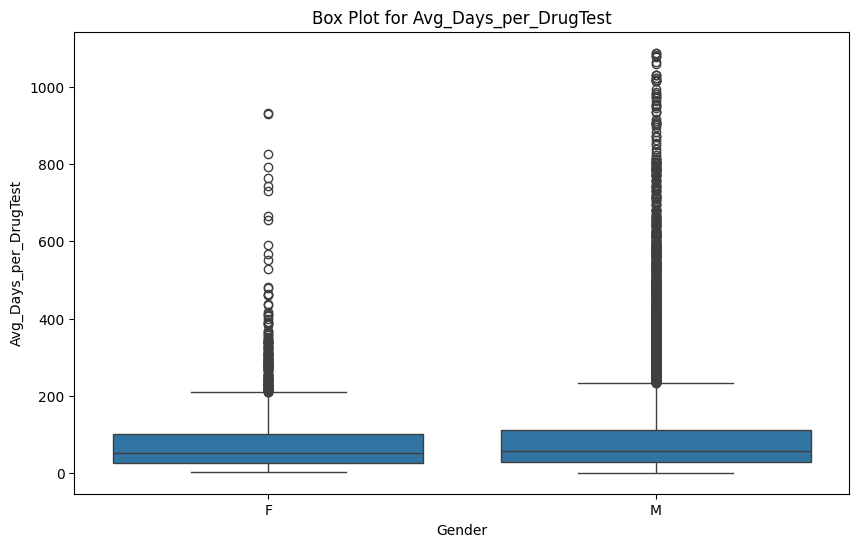

<ipython-input-6-933b3423e814>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):


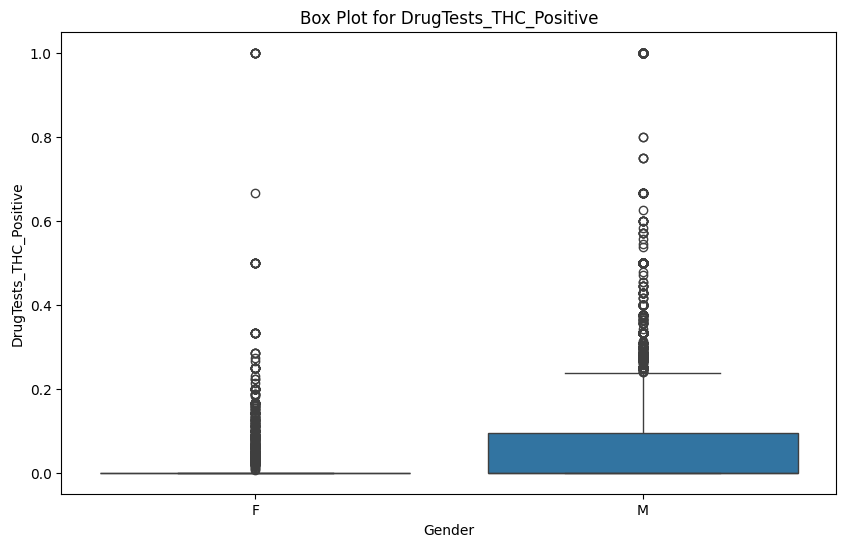

<ipython-input-6-933b3423e814>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):


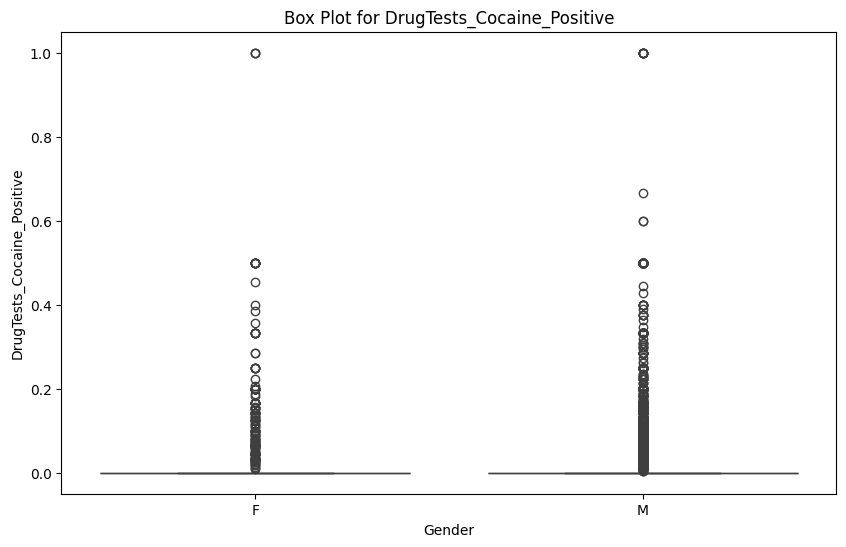

<ipython-input-6-933b3423e814>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):


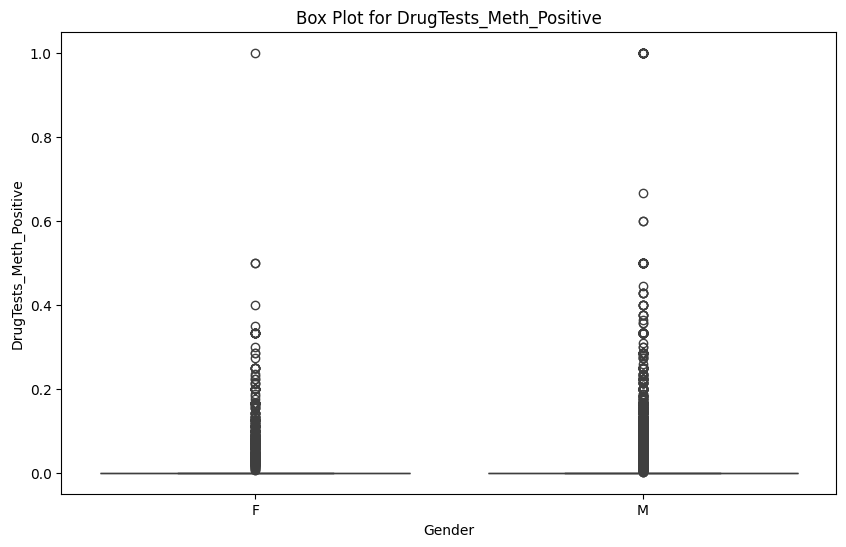

<ipython-input-6-933b3423e814>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):


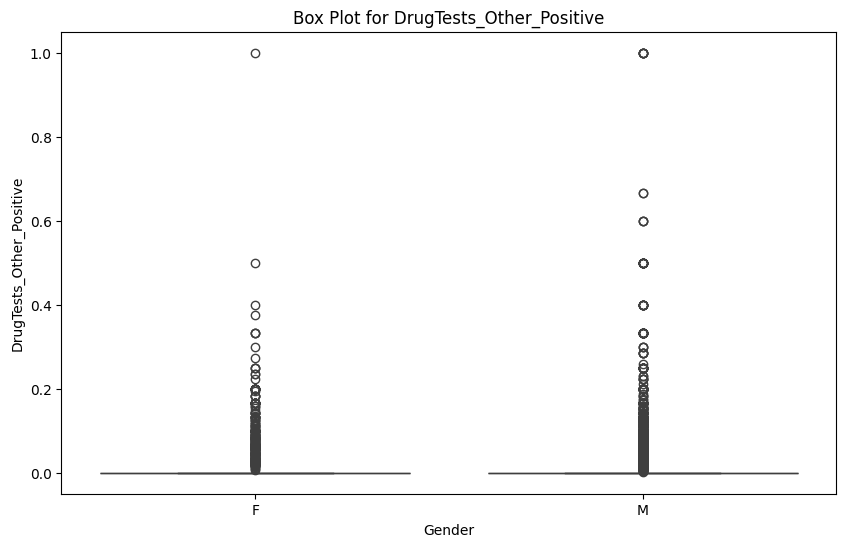

<ipython-input-6-933b3423e814>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):


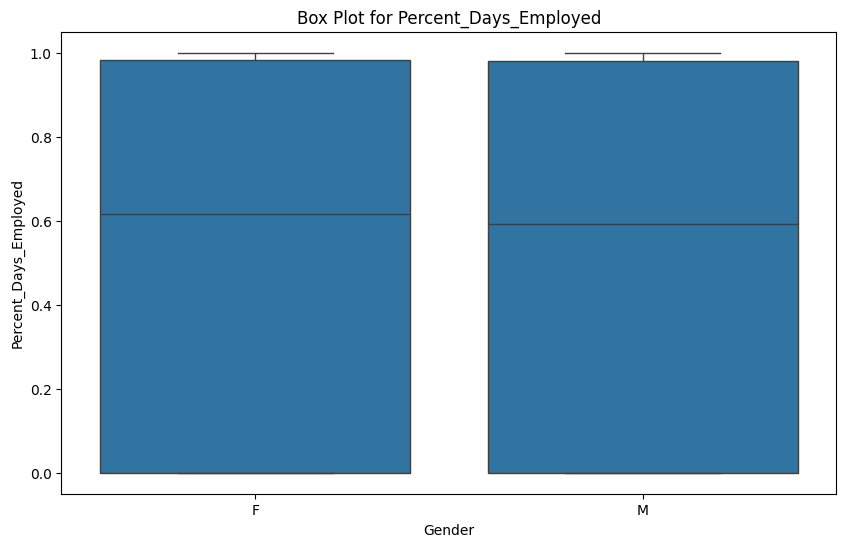

<ipython-input-6-933b3423e814>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):


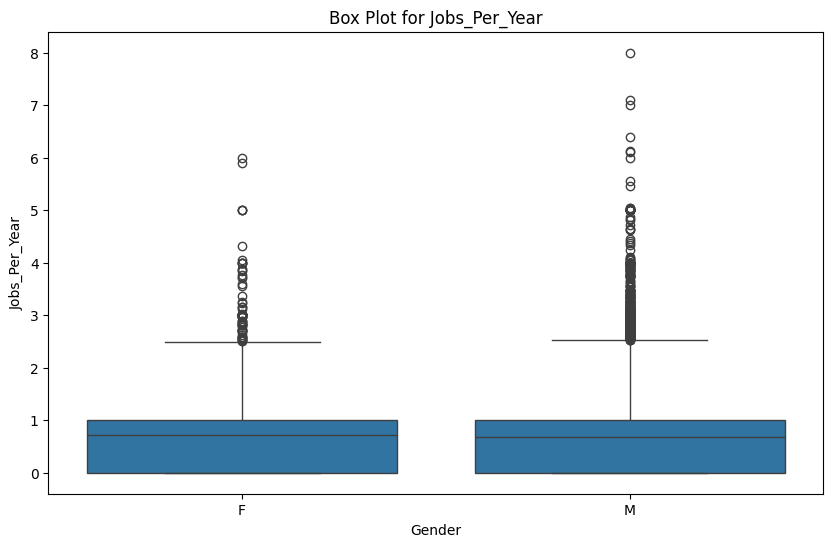

<ipython-input-6-933b3423e814>:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):


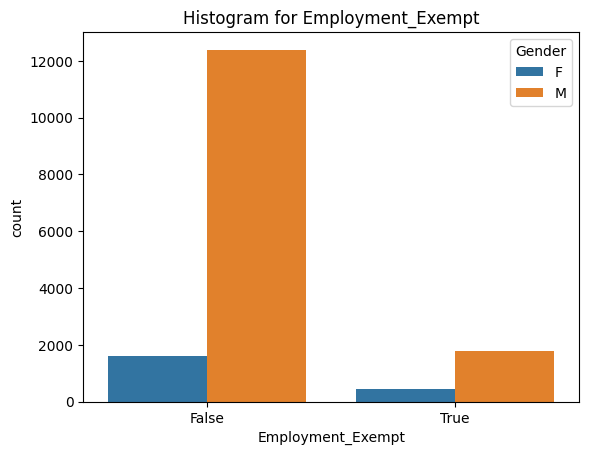

In [6]:
data_columns = preprocessed_data.columns.tolist()

for col in data_columns:
  if pd.api.types.is_categorical_dtype(preprocessed_data[col]):
        plt.figure()
        sns.countplot(data=preprocessed_data, x=col, hue='Gender')
        plt.title(f"Histogram for {col}")
        plt.show()
  elif pd.api.types.is_float_dtype(preprocessed_data[col]):
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=preprocessed_data, y=col, x='Gender')
        plt.title(f"Box Plot for {col}")
        plt.show()
  elif pd.api.types.is_int64_dtype(preprocessed_data[col]):
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=preprocessed_data, y=col, x='Gender')
        plt.title(f"Box Plot for {col}")
        plt.show()


In [7]:
# preprocessed_data.dtypes

In [8]:
outcomes = excluded_columns_data.drop(['ID', 'Training_Sample'], axis =1 )

all_false_mask = (~outcomes[['Recidivism_Arrest_Year1', 'Recidivism_Arrest_Year2', 'Recidivism_Arrest_Year3']].any(axis=1))

year_map = {
    'Recidivism_Arrest_Year1': 'One',
    'Recidivism_Arrest_Year2': 'Two',
    'Recidivism_Arrest_Year3': 'Three'
}

recidivism_arrest_any_index = outcomes[['Recidivism_Arrest_Year1', 'Recidivism_Arrest_Year2', 'Recidivism_Arrest_Year3']].idxmax(axis=1)

outcomes['Recidivism_Arrest_Any'] = recidivism_arrest_any_index.map(year_map)

outcomes.loc[all_false_mask, 'Recidivism_Arrest_Any'] = 'Zero'



In [9]:
outcomes.head()

,Recidivism_Within_3years,Recidivism_Arrest_Year1,Recidivism_Arrest_Year2,Recidivism_Arrest_Year3,Recidivism_Arrest_Any
0,False,False,False,False,Zero
1,True,False,False,True,Three
2,True,False,True,False,Two
3,False,False,False,False,Zero
4,True,True,False,False,One


In [10]:
X = pd.get_dummies(preprocessed_data)
y = pd.get_dummies(outcomes['Recidivism_Arrest_Any'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=200)


In [11]:
X_train.head()

,Residence_PUMA,Supervision_Risk_Score_First,Dependents,Prior_Arrest_Episodes_Felony,Prior_Arrest_Episodes_Misd,Prior_Arrest_Episodes_Violent,Prior_Arrest_Episodes_Property,Prior_Arrest_Episodes_Drug,Prior_Arrest_Episodes_PPViolationCharges,Prior_Arrest_Episodes_DVCharges,Prior_Arrest_Episodes_GunCharges,Prior_Conviction_Episodes_Felony,Prior_Conviction_Episodes_Misd,Prior_Conviction_Episodes_Prop,Prior_Conviction_Episodes_Drug,Delinquency_Reports,Program_Attendances,Program_UnexcusedAbsences,Residence_Changes,Avg_Days_per_DrugTest,DrugTests_THC_Positive,DrugTests_Cocaine_Positive,DrugTests_Meth_Positive,DrugTests_Other_Positive,Percent_Days_Employed,Jobs_Per_Year,Gender_F,Gender_M,Race_Black,Race_White,Age_at_Release_18-22,Age_at_Release_23-27,Age_at_Release_28-32,Age_at_Release_33-37,Age_at_Release_38-42,Age_at_Release_43-47,Age_at_Release_48 or older,Gang_Affiliated_False,Gang_Affiliated_True,Gang_Affiliated_Unknown,Supervision_Level_First_High,Supervision_Level_First_Specialized,Supervision_Level_First_Standard,Education_Level_College or Higher,Education_Level_High School or Lower,Prison_Offense_Drug Offense,Prison_Offense_Property Offense,Prison_Offense_Violent Offense,Prison_Years_1-2 years,Prison_Years_Greater than 2 to 3 years,Prison_Years_Less than 1 year,Prison_Years_More than 3 years,Prior_Conviction_Episodes_Viol_False,Prior_Conviction_Episodes_Viol_True,Prior_Conviction_Episodes_PPViolationCharges_False,Prior_Conviction_Episodes_PPViolationCharges_True,Prior_Conviction_Episodes_DomesticViolenceCharges_False,Prior_Conviction_Episodes_DomesticViolenceCharges_True,Prior_Conviction_Episodes_GunCharges_False,Prior_Conviction_Episodes_GunCharges_True,Prior_Revocations_Parole_False,Prior_Revocations_Parole_True,Prior_Revocations_Probation_False,Prior_Revocations_Probation_True,Condition_MH_SA_False,Condition_MH_SA_True,Condition_Cog_Ed_False,Condition_Cog_Ed_True,Condition_Other_False,Condition_Other_True,Violations_ElectronicMonitoring_False,Violations_ElectronicMonitoring_True,Violations_Instruction_False,Violations_Instruction_True,Violations_FailToReport_False,Violations_FailToReport_True,Violations_MoveWithoutPermission_False,Violations_MoveWithoutPermission_True,Employment_Exempt_False,Employment_Exempt_True
21165,20,4.0,3,4,3,2,1,1,1,False,False,0,4,1,1,0,10,0,1,104.500000,0.000000,0.0,0.0,0.000000,0.894737,1.000000,False,True,True,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,True,False,False,False,True,False,False,False,True,False,True,False,True,False,True,False,True,False,False,True,True,False,True,False,False,True,True,False,True,False,True,False,True,False,False,True
15077,16,8.0,0,9,1,0,1,1,5,False,False,0,2,0,0,4,0,0,3,61.047619,0.000000,0.0,0.0,0.047619,0.743370,0.569813,False,True,False,True,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,False,True,True,False,True,False,True,False,False,True,False,True,False,True,True,False
17051,8,7.0,1,4,5,1,0,2,2,True,False,0,1,0,0,4,0,0,2,205.500000,0.000000,0.0,0.0,0.000000,0.139903,0.444343,False,True,True,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,True,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,False,True,True,False,True,False,True,False
2837,10,10.0,3,10,5,3,5,5,4,True,False,3,4,3,2,4,10,0,0,8.186047,0.069767,0.0,0.0,0.000000,0.000000,0.000000,False,True,True,False,False,False,False,False,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,True,False,False,True,True,False,True,False,True,False,True,False,True,False,False,True,True,False,True,False,False,True,True,False,True,False,False,True
18751,4,2.0,0,2,0,1,1,0,0,False,False,0,0,0,0,0,0,0,0,113.000000,0.000000,0.0,0.0,0.000000

In [12]:
# fit Random Forests model
recidivism_rf = RandomForestRegressor(max_features=6
                                       ,random_state = 1)

recidivism_rf.fit(X_train,y_train)

# Predict values
y_pred_rf = recidivism_rf.predict(X_test)

# find the MSE
print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_test, y_pred_rf)))

Mean Squared Error: 0.15


In [13]:
# create a dataframe of feature importances and their corresponding column names
importances_recidivism_rf = pd.DataFrame({'Feature': X_train.columns, 'Importance': recidivism_rf.feature_importances_})
importances_recidivism_rf = importances_recidivism_rf.sort_values('Importance', ascending=False).reset_index(drop=True)

# display the table
print(importances_recidivism_rf)

                                              Feature  Importance
0                               Percent_Days_Employed    0.064654
1                                       Jobs_Per_Year    0.051033
2                               Avg_Days_per_DrugTest    0.050217
3                                      Residence_PUMA    0.038623
4                        Supervision_Risk_Score_First    0.034431
..                                                ...         ...
75                                           Gender_F    0.004033
76  Prior_Conviction_Episodes_DomesticViolenceChar...    0.004003
77  Prior_Conviction_Episodes_DomesticViolenceChar...    0.003846
78                            Gang_Affiliated_Unknown    0.003587
79                                           Gender_M    0.003468

[80 rows x 2 columns]


Boosting with CV

In [14]:
X = pd.get_dummies(preprocessed_data)
y = outcomes['Recidivism_Arrest_Any']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=200)


In [ ]:
# GridSearchCV Params
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': list(range(1, 92, 5))
}

# Gradient Boosting classifier
boost_recidivism = GradientBoostingClassifier(random_state=100, learning_rate=0.2)

# GridSearchCV
grid_search = GridSearchCV(estimator=boost_recidivism, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best Params
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters: ", best_params)
print("Best accuracy: {:.2f}".format(best_score))

# Predict
best_model = grid_search.best_estimator_
y_pred_boost = best_model.predict(X_test)

# Accurace
accuracy = accuracy_score(y_test, y_pred_boost)
print("Test accuracy: {:.2f}".format(accuracy))